In [ ]:
from graphviz import Digraph
import sys
if "../../.." not in sys.path:
    sys.path.append("../../..")
import numpy as np

In [ ]:
DEFAULT_MIN_TO_REDUCE=3


In [ ]:
def table_node(array,cellborder=1,image=None):
    if isinstance(cellborder,int):
        cellborder=[[cellborder for c in r]for r in array]
    table="""<<table BORDER="0" CELLBORDER="{}" CELLSPACING="0" CELLPADDING="{}">\n""".format(
        0 if image else 1,
        0 if image else 4)
    nrows=len(array)
    ncols=max([len(r) for r in array])
    images=[[None]*ncols]*nrows
    if isinstance(image,(list,tuple)):
        for r in range(nrows):
            for c in range(ncols):
                images[r][c]=image[r][c]
    else:
        if image:
            table+='<tr>\n'
            table+='<td rowspan="{}" fixedsize="true" height="{}" width="{}"><img src="{}" /></td>\n'.format(nrows+1,200,200,image)
            #table+='<td port="img"></td>'*ncols
            table+="</tr>\n"
    
    if image:
        for i,r in enumerate(array):
            table+='<tr>\n'
            for j,c in enumerate(r):
                table+='<td port="{}" border="{}">{}</td>\n'.format(
                    c[0],
                    0,
                    " " if images[i][j] is None else '<img src="{}" />'.format(images[i][j])
                )
            table+="</tr>\n"
    else:
        for i,r in enumerate(array):
            table+='<tr>\n'
            for j,c in enumerate(r):
                table+='<td port="{}" border="{}">{}</td>\n'.format(
                    c[0],
                    cellborder[i][j],
                    c[1]
                )
            table+="</tr>\n"
            
    table=table+"</table>>\n"
    return table

In [ ]:
class molNetGraphviz(Digraph):
    class_label="molNet Graph"
    def __init__(self,name,reduced=None,parent=None,min_to_reduce=DEFAULT_MIN_TO_REDUCE,label=None,img=None):
        super().__init__(name,node_attr={'shape': 'record'})
        
        self.attr(rankdir='LR',size="188", ranksep='1',newrank = "true")
        self.attr(compound='true')
        self.attr(splines = "true")
        self.attr(style="dotted")
        self.img=img
        if label is None:
            label=self.class_label
        if label:
            self.attr(label=label)
        else:
            self.attr(label="")
            
        if not name.startswith("cluster_"):
            name="cluster_"+name
        self.name=name
        
        if parent:
            if reduced is None:
                reduced=parent.reduced

            min_to_reduce=min(parent.min_to_reduce,min_to_reduce)
        
        if reduced is None:
            reduced=True
        
        self.parent=parent
        self.reduced=reduced
        self.min_to_reduce=min_to_reduce
        self.create();
    
    def create(self):
        pass

In [ ]:
class LinearGraph(molNetGraphviz):
    
    def __init__(self,layer_names,pre_layer=None,*args,**kwargs):
        
        if isinstance(layer_names,int):
            layer_names = [str(i+1) for i in range(layer_names)]
                
        self.layer_names=layer_names
        self.pre_layer=pre_layer
        super().__init__(*args,**kwargs)
        self.attr(style="invis")
        
        
    def create(self):
        if self.reduced and len(self.layer_names)>self.min_to_reduce:
            #try:
            #    int(self.layer_names[-1].rsplit("_",1)[1])
            #    self.layer_names[-1]=self.layer_names[-1].rsplit("_",1)[0]+"_n"
            #except:
            #    pass
            
            #try:
            #    int(self.layer_names[-1])
            #    self.layer_names[-1]="n"
            #except:
            #    pass
            with_red_node=True
            self.ports=["{}".format(f) for f in range(self.min_to_reduce-1)]+["n"]
            self.draw_ports=[[f,self.layer_names[i]] for i,f in enumerate(self.ports[:-1])]+[["reduce","..."],[self.ports[-1],self.layer_names[-1]]]
        else:
            with_red_node=False
            self.ports=["{}".format(i) for i in range(len(self.layer_names))]
            self.draw_ports=[[f,self.layer_names[i]] for i,f in enumerate(self.ports)]
            
        self.node_name="{}_l".format(self.name)
        self.node(self.node_name,
                  table_node(
                      np.array([[[fp,fn]] for fp,fn in self.draw_ports]),
                      #cellborder= 1 if not with_red_node else [[1] for _ in self.draw_ports[:-2]]+[[2],[1]]
                  image=self.img,
                  ),
                   shape="none",
                      
                      )
        #connect to prev layer
        if self.pre_layer:
            for j in self.pre_layer.ports:
                for k in self.ports:
                    self.edge(
                        "{}:{}".format(self.pre_layer.node_name,j),
                        "{}:{}".format(self.node_name,k)
                    )

In [ ]:
class GraphInpuGraph(LinearGraph):
    def __init__(self,nodes=None,min_to_reduce=DEFAULT_MIN_TO_REDUCE,*args,node_name="node",**kwargs):
        if nodes is None:
            nodes=15            
            
        if isinstance(nodes,int):
            nodes=["node_{}".format(i+1) for i in range(nodes)]

        self.nodes=nodes
        
        super().__init__(layer_names=nodes,*args,min_to_reduce=min_to_reduce,**kwargs)
      

In [ ]:
class AtomInputGraph(GraphInpuGraph):
    def __init__(self,nodes=None,*args,**kwargs):
        if nodes is None:
            nodes=15            
            
        if isinstance(nodes,int):
            nodes=["atom_{}".format(i+1) for i in range(nodes)]
            
        super(). __init__(*args,nodes=nodes,**kwargs)
        

In [ ]:
class FeatureGraph(molNetGraphviz):
    class_label=False
    def __init__(self,features,items,*args,**kwargs):
        if isinstance(features,int):
            features=["feat_{}".format(i+1) for i in range(features)]
        self.features=features
        self.items=items
        super(). __init__(*args,**kwargs)
    
    
    def get_connection_point(self,item,feat,):
        return "{}:{}".format(self.node_name,self.get_port(item,feat))
    
    def get_connection_point_by_index(self,item_index,feat_index):
        return self.get_connection_point(self.draw_items[item_index],self.feats[feat_index])
    
    def get_port(self,item,feat):
        return "i{}_{}".format(item,feat)
    
    def create(self):
        item_red=self.reduced and self.items>self.min_to_reduce
        
        if item_red:
            self.draw_items=list(range(self.min_to_reduce-1))+[self.items-1]
        else:
            self.draw_items=list(range(self.items))
        
        feat_red=self.reduced and len(self.features)>self.min_to_reduce
        if feat_red:
           # try:
           #     int(self.features[-1].rsplit("_",1)[1])
           #     self.features[-1]=self.features[-1].rsplit("_",1)[0]+"_n"
           # except:
           #     pass
            
            self.feats=self.features[:self.min_to_reduce-1]+[self.features[-1]]
            self.draw_features=[[f,f] for f in self.feats[:-1]]+[["reduce","..."],[self.feats[-1],self.feats[-1]]]
        else:
            self.feats=self.features.copy()
            self.draw_features=[[f,f] for f in self.feats]
        
        
        table_entries=[]
        table_borders=[]
        
        
        for i in self.draw_items[:-1]:
            for f in self.feats[:-1]:
                table_entries.append([[self.get_port(i,f),f]])
                table_borders.append([1])
                
            if feat_red:
                table_entries.append([["reduce","..."]])
                table_borders.append([1])
                
            table_entries.append([[self.get_port(i,self.feats[-1]),self.feats[-1]]])
            table_borders.append([1])
            table_entries.append([["space",""]])
            table_borders.append([0])
        
        if item_red:
            table_entries.append([["reduce","..."]])
            table_borders.append([1])
            table_entries.append([["space",""]])
            table_borders.append([0])
        
        for f in self.feats[:-1]:
            table_entries.append([[self.get_port(self.draw_items[-1],f),f]])
            table_borders.append([1])
        if feat_red:
            table_entries.append([["reduce","..."]])
            table_borders.append([1])
            
        table_entries.append([[self.get_port(self.draw_items[-1],self.feats[-1]),self.feats[-1]]])
        table_borders.append([1])
        
        
        self.node_name="{}_fnode".format(self.name,)
        
        self.node(self.node_name,
              table_node(np.array(table_entries),
                  np.array(table_borders)),
               shape="none"
                  )


In [ ]:
class FeatureCatGraph(FeatureGraph):
    class_label="Feature concat"
    def __init__(self,fgs2cat,*args,**kwargs):
        feats=0
        if "parent" not in kwargs:
            kwargs["parent"]=fgs2cat[0]
        for fg in fgs2cat:
            assert fg.items == fgs2cat[0].items
            feats+=len(fg.features)    
        self.fgs2cat=fgs2cat
        
        super(). __init__(features=feats,items=fgs2cat[0].items,*args,**kwargs)
    
    def create(self):
        super().create()
        
        fi_me = int(len(self.draw_features)/2)-1
        for fg in self.fgs2cat:
            fi = int(len(fg.draw_features)/2)-1
            for i,n in enumerate(self.draw_items):
                self.edge(fg.get_connection_point_by_index(i,fi),
                          self.get_connection_point_by_index(i,fi_me),
                         #ltail=fg.name
                         )
                #self.edge(fg.feature_nodes[i],n)
            

In [ ]:
class FeaturizerGraph(FeatureGraph):
    class_label="Featurizer"
    
    def __init__(self,parent,features,*args,**kwargs):
        super(). __init__(features=features,items=len(parent.layer_names),*args,parent=parent,**kwargs)
    
    def create(self):
        super().create()
        
        for i,n in enumerate(self.parent.ports):
            for j,f in enumerate(self.feats):
                self.edge("{}:{}".format(self.parent.node_name,n),self.get_connection_point_by_index(i,j))
        
        return
        for i,n in enumerate(self.parent.ports):
            for f in self.feats:
                self.edge("{}:{}".format(self.parent.node_name,n),"{}:{}".format(self.feature_nodes[i],f))
        
        try:
            self.edge("{}:reduce".format(self.parent.node_name),self.reduced_node_name,style="invis")
        except:
            pass
        

In [ ]:
class PoolingGraph(molNetGraphviz):
    class_label="Pooling layer"
    def __init__(self,parent,symbol="+",*args,**kwargs):
        self.symbol=symbol
        super(). __init__(*args,parent=parent,**kwargs)
    
    def create(self):
        feat_node_name="{}_pooled".format(self.name)
        self.layer=[LinearGraph(self.parent.features,name=feat_node_name,parent=self)]
        self.subgraph(self.layer[0])
        for i,f in enumerate(self.parent.feats):
            opname="{}_pool_op_{}".format(self.name,f)
            self.node(opname,
                  label=self.symbol,
                   shape="circle"
                  )
            self.edge(opname,"{}:{}".format(self.layer[0].node_name,self.layer[0].ports[i]))
            for j,item in enumerate(self.parent.draw_items):
                #for j,feat in enumerate(self.parent.feats):
                    #print(i,j)
                    self.edge(self.parent.get_connection_point_by_index(j,i),opname)
            #for n in self.parent.feature_nodes:
                 #self.edge("{}:{}".format(n,f),opname)

In [ ]:
class FunctionCall(molNetGraphviz):
    class_label=False
    
    def __init__(self,text,prenode,nextnode,*args,**kwargs):
        self.text=text
        self.prenode=prenode
        self.nextnode=nextnode
        super().__init__(*args,**kwargs)
    
    def create(self):
        opname="{}_fc_{}".format(self.name,self.text)
        self.node(opname,
                  label=self.text,
                   shape="circle"
                  )
        self.edge(self.prenode,opname)
        self.edge(opname,self.nextnode)

In [ ]:
class FeatureNNCombiGraph(molNetGraphviz):
    class_label="FCNN feature layer"
    def __init__(self,fg_input,n_output,hidden_layer=[],*args,**kwargs):
        self.fg_input=fg_input
        self.n_output=n_output
        self.hidden_layer=hidden_layer
        if "parent" not in kwargs:
            kwargs["parent"]=fg_input
        super().__init__(*args,**kwargs)
        
    def create(self):
        nng=FCNNGraph(
            [len(self.fg_input.features)]+self.hidden_layer+[self.n_output],
            name="{}_fcnn".format(self.name),parent=self
                     )
    
        
        fi = int(len(self.fg_input.draw_features)/2)-1
        
        for i,item in enumerate(self.fg_input.draw_items):
            self.edge(self.fg_input.get_connection_point_by_index(i,fi),nng.layer[0].node_name,lhead=nng.layer[0].name,)
        self.subgraph(nng)
        
         
        self.feature_graph=FeatureGraph(len(nng.layer[-1].layer_names),self.fg_input.items,name="{}_fnnf".format(self.name),parent=self)
        self.subgraph(self.feature_graph)
        
        fi = int(len(self.feature_graph.draw_features)/2)-1
        
        for i,item in enumerate(self.feature_graph.draw_items):
            #for j,feat in enumerate(self.feature_graph.draw_features):
        #for fgn in self.feature_graph.feature_nodes[:-1]:
                self.edge(nng.layer[-1].node_name,self.feature_graph.get_connection_point_by_index(i,fi),lhead=self.feature_graph.name)
        return 
            
        for fgn in self.feature_graph.feature_nodes[:-1]:
            self.edge(nng.layer[-1].node_name,fgn,)

        try:
            self.edge(nng.layer[-1].node_name,self.feature_graph.reduced_node_name,style="invis")
        except:
            pass

        self.edge(nng.layer[-1].node_name,self.feature_graph.feature_nodes[-1],)

In [ ]:
class FCNNGraph(molNetGraphviz):
    class_label="FCNN Graph"
    def __init__(self,layer_names,*args,**kwargs):
        self.layer_names=layer_names
        super(). __init__(*args,**kwargs)
        
    def create(self):
        g=None
        self.layer=[]
        for i,l in enumerate(self.layer_names):
            g=LinearGraph(l,pre_layer=g,parent=self,name="{}_l{}".format(self.name,i))
            self.subgraph(g)
            self.layer.append(g)

In [ ]:
class GraphConvGraph(molNetGraphviz):
    class_label=False
    def __init__(self,fg_in,f_out,*args,**kwargs):
        self.fg_in=fg_in
        self.f_out=f_out
        if "parent" not in kwargs:
            kwargs["parent"]=fg_in
        super(). __init__(*args,**kwargs)
    
    def create(self):
        self.feature_graph=FeatureGraph(self.f_out,self.fg_in.items,
                   parent=self,name="fg_conv")
        self.subgraph(self.feature_graph)

        gc = FunctionCall("graph conv",self.fg_in.node_name,self.feature_graph.node_name,name="gc",parent=self)
        self.subgraph(gc)

In [ ]:
from molNet.nn.models.graph_convolution import PoolSum
def _PoolSum_to_graphviz(self,parent,*args,**kwargs):
        return PoolingGraph(parent,*args,symbol="+",**kwargs)
PoolSum.to_graphviz=_PoolSum_to_graphviz


from molNet.nn.models.graph_convolution import PoolWeightedSum
def _PoolWeightedSum_to_graphviz(self,parent,name,label=None,*args,**kwargs):
        if label is None:
            label="PoolWeightSum layer"
        g=molNetGraphviz(name=name,*args,**kwargs,parent=parent,label=label)
        frn=FeatureNNCombiGraph(parent,n_output=1,name="{}_fcomb".format(name))
        g.subgraph(frn)
        pg = PoolingGraph(frn.feature_graph,name="{}_pool".format(name))
        g.subgraph(pg)
        return g

In [ ]:
PoolWeightedSum.to_graphviz=_PoolWeightedSum_to_graphviz


parent=molNetGraphviz(name="test",reduced=False)
parent.attr(nodesep="0", ranksep="1.3")
        

aig = AtomInputGraph(name="dd",parent=parent)
parent.subgraph(aig)

fg = FeaturizerGraph(aig,5,name="feats")
parent.subgraph(fg)


frn=FeatureNNCombiGraph(fg,n_output=3,hidden_layer=[2],name="fcomb")
parent.subgraph(frn)

frn_c=FeatureGraph(frn.feature_graph.features,frn.feature_graph.items,
                   parent=frn.feature_graph,name="fcomb_c")
parent.subgraph(frn_c)

fc1 = FunctionCall("softmax",frn.feature_graph.node_name,frn_c.node_name,name="fc1",)
parent.subgraph(fc1)

fcg=FeatureCatGraph([fg,frn_c],name="cat1")
parent.subgraph(fcg)
#GC

gcnn=GraphConvGraph(fcg,f_out=2,name="gcnn")
parent.subgraph(gcnn)

fcg2=FeatureCatGraph([gcnn.feature_graph,frn_c],name="cat2")
parent.subgraph(fcg2)

fnn3=FeatureNNCombiGraph(fcg2,n_output=1,name="nn3")
parent.subgraph(fnn3)


#in_feats=feats
#feats =self.nn1(in_feats)
#feats =self.nn2(feats)
#feats = self.softmax(feats)

#gcfeats =self.gc(torch.cat([in_feats,feats],1),edges,edge_weight = torch.ones((edges.size(1), ),device=edges.device))
#feats =self.nn3(torch.cat([gcfeats,feats],1))

#feats = self.softmax(feats)

##nn reduce

#fcg=FeatureCatGraph([fg,frn.feature_graph],name="fcomb")
#parent.subgraph(fcg)


#pg = PoolingGraph(frn.feature_graph,name="pool")
#pg = PoolingGraph(fcg,name="pool")
#parent.subgraph(pg)

#fcnn=FeatureNNCombiGraph(fg,3,hidden_layer=[2],name="e")
#parent.subgraph(fcnn)



#pg = PoolingGraph(fg,name="pool")
#parent.subgraph(pg)

parent.format='png'           
#g.engine="fdp"
from IPython.display import Image
Image(parent.render())

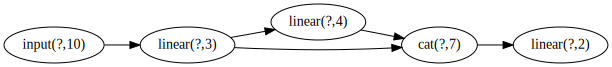

In [391]:
import torch
import numpy

FULL_REPRES=3
RED_REPRES=2
SYMB_REPRES=1
NO_REPRES=0

REDUCE_NEVER=99999
STYLE_SYMBOLIC=1
STYLE_IMAGE=1

class nnViz(Digraph):
    def __init__(self,name,*args,**kwargs):
        super().__init__(name=name,*args,**kwargs)
        self.attr(rankdir='LR',
                  #size="188", ranksep='1',newrank = "true"
                 )


        
def nnViz_linear_layer(x,level,reduce_in,style,name,dim=-1, symbol_text="linear"):
    ports=["p{}".format(i) for i in range(x.shape[dim])]
    labels=[i for i in range(x.shape[dim])]
    
    g=nnViz(name=name)
    
    node_name=name+"_n"
    if style==STYLE_SYMBOLIC:
        if level==FULL_REPRES:
            g.node(name=node_name,label=table_node([[(p,labels[i])] for i,p in enumerate(ports)]),
                   shape="none"
                  )
            x.viz_op=["{}:{}".format(node_name,p) for p in ports]
        elif level==SYMB_REPRES:
            g.node(name=node_name,label=symbol_text)
            x.viz_op=[node_name]
        else:
            raise NotImplementedError()
    else:
        raise NotImplementedError()
    
    return g
    


def nnViz_linear_forward(self,x,level=FULL_REPRES,reduce_in=REDUCE_NEVER,style=STYLE_SYMBOLIC,name=None):
    if name is None:
            name=self.__class__.__name__
            
    next_params={'level': level-1 if reduce_in is 0 else level,
                 'reduce_in':max(0,reduce_in-1),
                 'style':style,
                }

    y=self(x)
    symbol_text="linear({})".format("?,"+",".join(str(i) for i in y.shape[1:]))
    
    g=nnViz_linear_layer(y,level=level,reduce_in=reduce_in,style=style,name=name,
                        symbol_text=symbol_text,
                        )
    
    
    if style==STYLE_SYMBOLIC:
        if level==FULL_REPRES:            
            for op in y.viz_op:
                for ip in x.viz_op:
                    g.edge(ip,op)
                    
        elif level==SYMB_REPRES:
            node_name=name+"_n"
            g.node(name=node_name,label=symbol_text)
            y.viz_op=[node_name]
            for ip in x.viz_op:
                g.edge(ip,node_name)
            
        else:
            raise NotImplementedError()
    else:
        raise NotImplementedError()
    

    return g,y

torch.nn.Linear.graphviz_forward=nnViz_linear_forward

def nnViz_cat_forward(x,level=FULL_REPRES,reduce_in=REDUCE_NEVER,style=STYLE_SYMBOLIC,name=None):
    nx = torch.cat(x,dim=1)
    symbol_text="cat({})".format("?,"+",".join(str(i) for i in nx.shape[1:]))
    
    g=nnViz_linear_layer(nx,level=level,reduce_in=reduce_in,style=style,name=name,symbol_text=symbol_text)
    if style==STYLE_SYMBOLIC:
        if level==FULL_REPRES:
            i=0
            for j,ipt in enumerate (x):
                for k in ipt.viz_op:
                    g.edge(k,nx.viz_op[i])
                    i+=1
        elif level==SYMB_REPRES:
            for j,ipt in enumerate (x):
                for k in ipt.viz_op:
                    g.edge(k,nx.viz_op[0])
        else:
            raise NotImplementedError()
    else:
        raise NotImplementedError()
    return g,nx


class TestModel(torch.nn.Module):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.nn1=torch.nn.Linear(10,3)
        self.nn2=torch.nn.Linear(3,4)
        self.nn3=torch.nn.Linear(7,2)
        
    def forward(self,x):
        x1=self.nn1(x)
        x2=self.nn2(x1)
        cat=torch.cat([x1,x2],dim=1)
        x3=self.nn3(cat)
        return x
    
    def graphviz_forward(self,x,level=FULL_REPRES,reduce_in=REDUCE_NEVER,style=STYLE_SYMBOLIC,name=None):
        if name is None:
            name=self.__class__.__name__
            
        next_params={'level': level-1 if reduce_in is 0 else level,
                     'reduce_in':max(0,reduce_in-1),
                     'style':style,
                    }
        
        g=nnViz(name=name)
        
        ip=nnViz_linear_layer(x,level=level,reduce_in=reduce_in,style=style,name=name+"_ip",
                             symbol_text="input({})".format("?,"+",".join(str(i) for i in x.shape[1:]))
                            )
        g.subgraph(ip)
    
        nn1g,x1=self.nn1.graphviz_forward(x,**next_params,name=name+"_nn1",)
        g.subgraph(nn1g)
        
        nn2g,x2=self.nn2.graphviz_forward(x1,**next_params,name=name+"_nn2",)
        g.subgraph(nn2g)
        
        
        catg,x=nnViz_cat_forward([x1,x2],**next_params,name=name+"_cat",)
        g.subgraph(catg)
        
        
        nn3g,x=self.nn3.graphviz_forward(x,**next_params,name=name+"_nn3",)
        g.subgraph(nn3g)
    
        return g,x
        
    
model=TestModel()


x=torch.Tensor(numpy.random.random([32,10]))
model(x)

g,x=model.graphviz_forward(x,level=SYMB_REPRES)
g

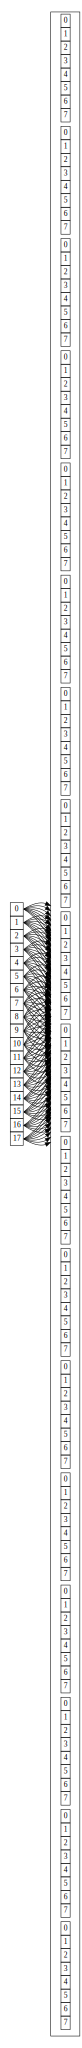

In [400]:
from molNet.mol  import molecules
from molNet.featurizer.atom_featurizer import atom_degree_one_hot,atom_symbol_hcnopsclbr_one_hot
import rdkit

def nnViz_feature_layer(feats,graph,level=FULL_REPRES,reduce_in=REDUCE_NEVER,style=STYLE_SYMBOLIC,name=None):
    
    nnodes=feats.shape[0]
    nfeats=feats.shape[1]
    labels=[i for i in range(nfeats)]
    
    g=nnViz(name=name)
    
    node_name=name+"_n"
    if style==STYLE_SYMBOLIC:
        if level==FULL_REPRES:
            table_entries=[]
            table_borders=[]
            ports=[]
            
            for n in range(nnodes):
                subports=[]
                for i in range(nfeats):
                    port="p{}_{}".format(n,i)
                    table_entries.append([[port,labels[i]]])
                    table_borders.append([1])
                    subports.append(port)
                ports.append(subports)
                table_entries.append([["space",""]])
                table_borders.append([0])
                
            g.node(name=node_name,label=table_node(table_entries,cellborder=table_borders),
                   shape="record")
            viz_op=[["{}:{}".format(node_name,p) for p in sp] for sp in ports]
            
            if hasattr(feats,"viz_op"):
                if len(feats.viz_op)==nnodes:
                    for i,nip in enumerate(feats.viz_op):
                        for fp in viz_op[i]:
                            g.edge(nip,fp)
            feats.viz_op=viz_op
            
        elif level==SYMB_REPRES:
            raise NotImplementedError()
            g.node(name=node_name,label=symbol_text)
            x.viz_op=[node_name]
        else:
            raise NotImplementedError()
    else:
        raise NotImplementedError()
    
    return g

class GraphTestModel(torch.nn.Module):
    def __init__(self,ips,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.nn1=torch.nn.Linear(ips,3)
        
    def forward(self,batch):
        x1=self.nn1(batch.x)
        return x1
    
    def graphviz_forward(self,batch,level=FULL_REPRES,reduce_in=REDUCE_NEVER,style=STYLE_SYMBOLIC,name=None):
        if name is None:
            name=self.__class__.__name__
            
        next_params={'level': level-1 if reduce_in is 0 else level,
                     'reduce_in':max(0,reduce_in-1),
                     'style':style,
                    }
        
        
        g=nnViz(name=name)
        
        gip = nnViz_linear_layer(batch.x,dim=0,**next_params,name=name+"_gip",
                             #symbol_text="input({})".format(x.shape[0])
                                )
        g.subgraph(gip)
        
        fip = nnViz_feature_layer(batch.x,batch.mol_graph,**next_params,name=name+"_fip")
        g.subgraph(fip)
        
        
        
        #g.edge()
        
        return g,batch.x
        
    

mol = molecules.Molecule(rdkit.Chem.MolFromSmiles("COc1ccccc1[N+](=O)[O-]"))
mol_graph = mol.to_molgraph()
mol_graph.featurize(atom_degree_one_hot,atom_symbol_hcnopsclbr_one_hot)
gip=mol_graph.to_graph_input(with_mol_graph=True)

model=GraphTestModel(gip.x.shape[1])

model(gip)

g,x=model.graphviz_forward(gip,
                           #level=SYMB_REPRES
                          )
#print(str(g))
g

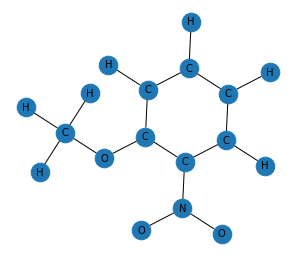